Installation, import, SparkSession

In [4]:
#install pyspark
! pip install pyspark

In [5]:
#create a sparksession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("spark").getOrCreate()

Load and explore data

In [6]:
#create a spark dataframe
df = spark.read.csv('Admission_Predict_Ver1.1.csv', header=True, inferSchema=True)

In [7]:
#display dataframe
df.show(10)

+---------+---------+-----------+-----------------+---+---+-----+--------+---------------+
|Serial No|GRE Score|TOEFL Score|University Rating|SOP|LOR|  GPA|Research|Chance of Admit|
+---------+---------+-----------+-----------------+---+---+-----+--------+---------------+
|        1|      337|        118|                4|4.5|4.5| 3.86|       1|           0.92|
|        2|      324|        107|                4|4.0|4.5|3.548|       1|           0.76|
|        3|      316|        104|                3|3.0|3.5|  3.2|       1|           0.72|
|        4|      322|        110|                3|3.5|2.5|3.468|       1|            0.8|
|        5|      314|        103|                2|2.0|3.0|3.284|       0|           0.65|
|        6|      330|        115|                5|4.5|3.0|3.736|       1|            0.9|
|        7|      321|        109|                3|3.0|4.0| 3.28|       1|           0.75|
|        8|      308|        101|                2|3.0|4.0| 3.16|       0|           0.68|

In [8]:
#get the no.of rows & columns
print((df.count(),len(df.columns)))

(500, 9)


In [9]:
#print schema
df.printSchema() 

root
 |-- Serial No: integer (nullable = true)
 |-- GRE Score: integer (nullable = true)
 |-- TOEFL Score: integer (nullable = true)
 |-- University Rating: integer (nullable = true)
 |-- SOP: double (nullable = true)
 |-- LOR: double (nullable = true)
 |-- GPA: double (nullable = true)
 |-- Research: integer (nullable = true)
 |-- Chance of Admit: double (nullable = true)



In [10]:
#get the summary statistics
df1 = df.describe().show()

+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|        Serial No|         GRE Score|      TOEFL Score|University Rating|               SOP|               LOR|               GPA|          Research|    Chance of Admit|
+-------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|  count|              500|               500|              500|              500|               500|               500|               500|               500|                500|
|   mean|            250.5|           316.472|          107.192|            3.114|             3.374|             3.484|3.4305760000000007|              0.56| 0.7217399999999996|
| stddev|144.4818327679989|11.295148372354712|6.081867659564538|1.143511800759815|0.9910036207566072|0.92

Clean the data

In [11]:
#drop the unnecessary column
df = df.drop('Serial No')

In [12]:
#display the dataframe
df.show()

+---------+-----------+-----------------+---+---+-----+--------+---------------+
|GRE Score|TOEFL Score|University Rating|SOP|LOR|  GPA|Research|Chance of Admit|
+---------+-----------+-----------------+---+---+-----+--------+---------------+
|      337|        118|                4|4.5|4.5| 3.86|       1|           0.92|
|      324|        107|                4|4.0|4.5|3.548|       1|           0.76|
|      316|        104|                3|3.0|3.5|  3.2|       1|           0.72|
|      322|        110|                3|3.5|2.5|3.468|       1|            0.8|
|      314|        103|                2|2.0|3.0|3.284|       0|           0.65|
|      330|        115|                5|4.5|3.0|3.736|       1|            0.9|
|      321|        109|                3|3.0|4.0| 3.28|       1|           0.75|
|      308|        101|                2|3.0|4.0| 3.16|       0|           0.68|
|      302|        102|                1|2.0|1.5|  3.2|       0|            0.5|
|      323|        108|     

In [13]:
#check for null values
for i in df.columns:
  print(i+":", df[df[i].isNull()].count())

GRE Score: 0
TOEFL Score: 0
University Rating: 0
SOP: 0
LOR: 0
GPA: 0
Research: 0
Chance of Admit: 0


Correlation, feature selection

In [14]:
# correlation analysis
for col in df.columns:
  print('Correlation of {} to admit probability is {}'.format(col,df.stat.corr('Chance of Admit',col)))

Correlation of GRE Score to admit probability is 0.8103506354632598
Correlation of TOEFL Score to admit probability is 0.7922276143050823
Correlation of University Rating to admit probability is 0.6901323687886892
Correlation of SOP to admit probability is 0.6841365241316723
Correlation of LOR to admit probability is 0.6453645135280112
Correlation of GPA to admit probability is 0.8824125749045744
Correlation of Research to admit probability is 0.5458710294711379
Correlation of Chance of Admit to admit probability is 1.0


In [15]:
pandasDF = df.toPandas()
df.describe().show()

+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|summary|         GRE Score|      TOEFL Score|University Rating|               SOP|               LOR|               GPA|          Research|    Chance of Admit|
+-------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-------------------+
|  count|               500|              500|              500|               500|               500|               500|               500|                500|
|   mean|           316.472|          107.192|            3.114|             3.374|             3.484|3.4305760000000007|              0.56| 0.7217399999999996|
| stddev|11.295148372354712|6.081867659564538|1.143511800759815|0.9910036207566072|0.9254495738978191|0.2419251201332821|0.4968840786090358|0.14114040395030228|
|    min|               290|      

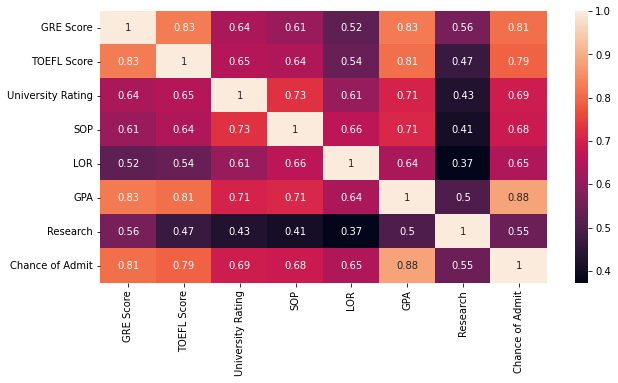

In [16]:
# temporary conversion to pandas for heatmap
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,5))
sns.heatmap(pandasDF.corr(), annot=True)

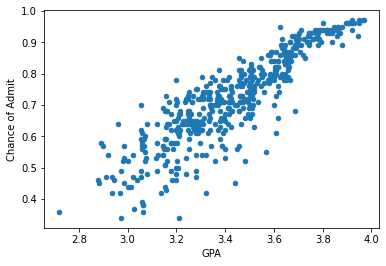

In [17]:
pandasDF.plot(x ='GPA', y='Chance of Admit', kind = 'scatter')	


In [18]:
# feature selection
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['GRE Score', 'TOEFL Score', 'GPA'], outputCol = 'features')

In [19]:
#display dataframe
output_data = assembler.transform(df)
output_data.show()

+---------+-----------+-----------------+---+---+-----+--------+---------------+-------------------+
|GRE Score|TOEFL Score|University Rating|SOP|LOR|  GPA|Research|Chance of Admit|           features|
+---------+-----------+-----------------+---+---+-----+--------+---------------+-------------------+
|      337|        118|                4|4.5|4.5| 3.86|       1|           0.92| [337.0,118.0,3.86]|
|      324|        107|                4|4.0|4.5|3.548|       1|           0.76|[324.0,107.0,3.548]|
|      316|        104|                3|3.0|3.5|  3.2|       1|           0.72|  [316.0,104.0,3.2]|
|      322|        110|                3|3.5|2.5|3.468|       1|            0.8|[322.0,110.0,3.468]|
|      314|        103|                2|2.0|3.0|3.284|       0|           0.65|[314.0,103.0,3.284]|
|      330|        115|                5|4.5|3.0|3.736|       1|            0.9|[330.0,115.0,3.736]|
|      321|        109|                3|3.0|4.0| 3.28|       1|           0.75| [321.0,109

Linear Regression Model

In [20]:
#import Linearregression and create final data
from pyspark.ml.regression import LinearRegression
final_data = output_data.select('features','Chance of Admit')

In [21]:
#print schema of final data
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- Chance of Admit: double (nullable = true)



In [22]:
#split the dataset into training and testing set
train, test = final_data.randomSplit([0.7,0.3])

In [23]:
#build & train the model
models = LinearRegression(featuresCol='features',labelCol='Chance of Admit')
model = models.fit(train)

In [24]:
#get coefficients & intercept
print("coefficient:",model.coefficients)
print("intercept:",model.intercept)

coefficient: [0.0028757391802221085,0.003093711804069862,0.34622374200767586]
intercept: -1.7097005687238607


In [25]:
#get summary of the model
summary = model.summary

In [26]:
#print the rmse & r2 score
print('RMSE', summary.rootMeanSquaredError)
print('r2 score', summary.r2)

RMSE 0.06272939984691808
r2 score 0.8028867571237782


In [27]:
print("Accuracy: ", format(summary.r2*100))

Accuracy:  80.28867571237782


Evaluation

In [28]:
#transform on the test data
predictions = model.transform(test)

In [29]:
#display the predictions
predictions.show(20)

+-------------------+---------------+-------------------+
|           features|Chance of Admit|         prediction|
+-------------------+---------------+-------------------+
|[290.0,104.0,2.984]|           0.45| 0.4791414673147214|
|  [295.0,93.0,2.88]|           0.46|0.42348206420226475|
|  [295.0,99.0,3.06]|           0.57|  0.504364608588066|
|[295.0,101.0,3.144]|           0.69| 0.5396348265248503|
| [296.0,99.0,3.212]|           0.61| 0.5598663565534547|
| [297.0,98.0,3.068]|           0.59| 0.5097921650805017|
| [297.0,100.0,3.16]|           0.52| 0.5478321729533477|
|[298.0,101.0,3.076]|           0.53| 0.5247188296089949|
|[299.0,100.0,2.968]|           0.42| 0.4871086928483179|
|[299.0,100.0,3.208]|           0.63| 0.5702023909301603|
|[300.0,104.0,3.264]|           0.71| 0.6048415068790916|
|[301.0,100.0,3.216]|           0.67| 0.5787236592266658|
|[301.0,104.0,3.156]|           0.68| 0.5703250819224848|
|[301.0,104.0,3.248]|           0.68| 0.6021776661871909|
|  [302.0,99.0

In [30]:
predictions = predictions.toPandas()

Text(0, 0.5, 'Predicted Admission Probability')

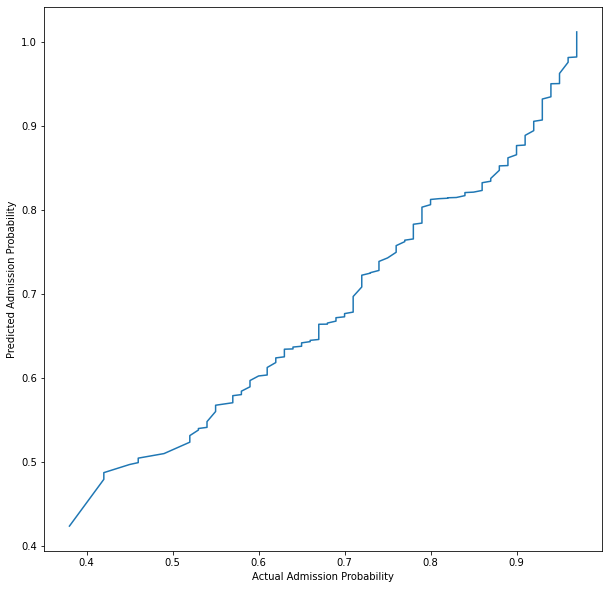

In [31]:
x = predictions['Chance of Admit'].sort_values()
y = predictions['prediction'].sort_values()
plt.figure(figsize=(10,10))
plt.plot(x, y)
plt.xlabel("Actual Admission Probability")
plt.ylabel("Predicted Admission Probability")

In [32]:
predictions=spark.createDataFrame(predictions) 

In [33]:
#evaluate the model 
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='Chance of Admit', metricName='r2')
print('r2 on the test data', evaluator.evaluate(predictions))

r2 on the test data 0.8018335383282513


In [34]:
print("Accuracy: ", format(summary.r2*100))

Accuracy:  80.28867571237782


In [35]:
#save the model
model.save("model")

In [36]:
#load the model
from pyspark.ml.regression import LinearRegressionModel
model = LinearRegressionModel.load('model')